# Downgrade Attack Detection System

## Overview
This notebook implements a three-stage hybrid system for detecting WPA3 downgrade attacks using:
- Baseline Adaptive feature selection
- Real-time detection and prevention (RDP)
- classifier for classification using the labeled traffic detected in RDP

## Stages
### Stage 1:Baseline Adaptive feature selection : Entropy Calculation and adpative feature selection
Calculates the entropy of numeric features in normal and attack traffic to assess variability.

Selects features where the entropy difference between normal and attack traffic exceeds a threshold.

### Stage 2: Real-time Detection and Classification
Uses the selected features to detect and classify downgrade attacks from live or segmented input CSVs.


#Access to your drive -where the dataset already uploaded

\

> **📌 Note**  
> This notebook supports downgrade attack detection based on CSV inputs.  
> It is structured for clarity, and all stages are modular. Make sure to update file paths as needed.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Feature: wlan_rsna_eapol.keydes.msgnr, Attack Entropy: 0.0000, Normal: 0.0000, Diff: 0.0000
Feature: wlan.rsn.akms.type, Attack Entropy: 0.4769, Normal: 0.4769, Diff: 0.0000
Feature: eapol.keydes.type, Attack Entropy: 0.0000, Normal: 0.0000, Diff: 0.0000
Feature: wlan.fixed.auth.alg, Attack Entropy: 0.0000, Normal: 0.0000, Diff: 0.0000
Feature: wlan.fixed.status_code, Attack Entropy: 0.0000, Normal: 0.0000, Diff: 0.0000
Feature: wlan.fc.subtype, Attack Entropy: 0.1465, Normal: 0.1465, Diff: 0.0000
Feature: wlan.rsn.akms.count, Attack Entropy: 0.4769, Normal: 0.4769, Diff: 0.0000
Feature: wlan.fixed.finite_cyclic_group, Attack Entropy: 0.0000, Normal: 0.0000, Diff: 0.0000
Feature: wlan.fc.retry, Attack Entropy: 0.0950, Normal: 0.0950, Diff: 0.0000
Feature: frame.number, Attack Entropy: 0.9994, Normal: 0.9994, Diff: 0.0000
Feature: wlan.fixed.beacon, Attack Entropy: 0.5349, Normal: 0.5349, Diff: 0.0000
Feature: wlan_radio.channel, Attack Entropy: 0.1059, Normal: 0.1059, Diff: 0.0000
Feat

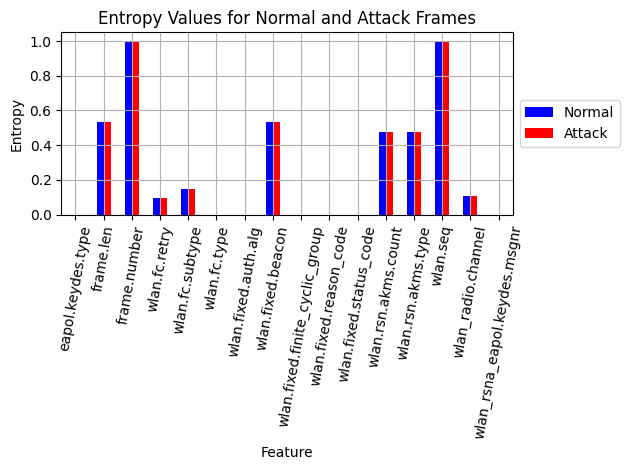

In [12]:
#stage 1
# -*- coding: utf-8 -*-
#This Code contain the preprocessing stage of filtering and normalization along with the baseline stage (Offline training )that output the adpative set
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def calculate_entropy(df):
        # ---- Filtering  ----
    target_bssid = "d6:7e:a7:8e:35:cb"
    filtered_df = df[df['wlan.sa'] == target_bssid]
    filtered_df = filtered_df[filtered_df['wlan.fc.subtype'].isin([8, 5])]
    numeric_columns = filtered_df.select_dtypes(include=[np.number])

    # ---- Z-Score Normalization ----
    normalized_df = numeric_columns.copy()
    for col in normalized_df.columns:
        mean = normalized_df[col].mean()
        std = normalized_df[col].std()
        if std == 0:
            std = 1  # avoid divide by zero
        normalized_df[col] = (normalized_df[col] - mean) / std

    entropies = {}
    for column in normalized_df.columns:
        feature_data = normalized_df[column].replace([np.inf, -np.inf, np.nan], 0)
        feature_data = feature_data[feature_data != 0]

        try:
            probabilities, _ = np.histogram(feature_data, bins=2, density=True)
            feature_entropy = entropy(probabilities, base=2)
            if np.isnan(feature_entropy):
                feature_entropy = 0.0
        except Exception:
            feature_entropy = 0.0

        entropies[column] = feature_entropy

    return entropies

# --- Load attack and normal traffic datasets (e.g., WPA3-TM, WPA3-SAE, or Temporary Condition scenarios)
file_path_1 = '/content/drive/My Drive/AA/WPA3_TM_normal.csv'
file_path_2 = '/content/drive/My Drive/AA/WPA3_TM_attack.csv'

normal_df = pd.read_csv(file_path_2)
attack_df = pd.read_csv(file_path_2)

# Determine common features
common_features = list(set(normal_df.columns) & set(attack_df.columns))

# Calculate entropy
normal_entropies = calculate_entropy(normal_df[common_features])
attack_entropies = calculate_entropy(attack_df[common_features])

# Combine entropy into dataframe for plotting
normal_entropies_df = pd.DataFrame({'Normal': list(normal_entropies.values())}, index=normal_entropies.keys())
attack_entropies_df = pd.DataFrame({'Attack': list(attack_entropies.values())}, index=attack_entropies.keys())
entropies_df = pd.concat([normal_entropies_df, attack_entropies_df], axis=1, sort=True)

# ---- Adaptive set selection (diff > 0.0) ----
threshold = 0.0
adaptive_set = []
for f in attack_entropies:
    normal_val = normal_entropies.get(f, 0)
    diff = abs(attack_entropies[f] - normal_val)
    if diff > threshold:
        adaptive_set.append(f)
    print("Feature: {}, Attack Entropy: {:.4f}, Normal: {:.4f}, Diff: {:.4f}".format(
        f, attack_entropies[f], normal_val, diff))

print("\n Adaptive (high-entropy) feature set:")
for f in adaptive_set:
    print(" -", f)


# Load selected adaptive features


pd.DataFrame({'Adaptive_Features': adaptive_set}).to_csv('adaptive_features.csv', index=False)
#adaptive_set = pd.read_csv('adaptive_features.csv')['adaptive_set'].tolist()

# ---- Plotting entropy bar chart ----
entropies_df.plot(kind='bar', color=['blue', 'red'])
plt.xlabel('Feature')
plt.ylabel('Entropy')
plt.title('Entropy Values for Normal and Attack Frames')
plt.xticks(rotation=80)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Detection and prevention
# -*- coding: utf-8 -*-
import psutil
import os
import time
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # in megabytes

def get_cpu_usage():
    return psutil.cpu_percent()

class DowngradeAttackDetector:
    def __init__(self):
        self.sliding_window_count = 0
        self.total_packets = 0
        self.attack_detected = 0
        self.normal_detected = 0
        self.baseline_thresholds = {}
        self.blacklist_file = pd.DataFrame(columns=['wlan.sa'])

    def block_traffic(self, source_ip):
        print("Blocking traffic from....", source_ip)

    def calculate_mad_threshold(self, data):
        # Calculate Mean Absolute Deviation for a pandas Series
        mad = (data - data.mean()).abs().mean()
        return mad

    def detect_anomalies(self, real_time_data, set_A):
        exempted_feature = 'wlan.rsn.akms.count'
        exceeding_count = 0
        source_bssid = ''

        for column in set_A:
            # Check if the column exists in the real_time_data DataFrame
            if column not in real_time_data.columns:
                print(f"Warning: Column '{column}' not found in real-time data. Skipping.")
                continue

            if column not in self.baseline_thresholds:
                self.total_packets += 1
                # Ensure data passed to calculate_mad_threshold is not empty
                if not real_time_data[column].empty:
                    self.baseline_thresholds[column] = self.calculate_mad_threshold(real_time_data[column])
                else:
                    self.baseline_thresholds[column] = 0.0 # Set a default if data is empty

            # Check if the column exists in real_time_data before accessing it
            if column not in real_time_data.columns:
                print(f"Warning: Column '{column}' not found in real-time data during anomaly detection. Skipping.")
                continue

            # Check for potential division by zero in normalization if std is 0
            if real_time_data[column].std() != 0:
                feature_normalized = (real_time_data[column] - real_time_data[column].mean()) / real_time_data[column].std()
            else:
                 # Handle cases where standard deviation is zero (all values are the same)
                 feature_normalized = real_time_data[column] - real_time_data[column].mean() # This will be all zeros

            # Check if feature_normalized is empty before calculating value_counts
            if not feature_normalized.empty and not feature_normalized.value_counts().empty:
                feature_entropy = entropy(feature_normalized.value_counts(), base=2)
            else:
                feature_entropy = 0.0 # Set entropy to 0 if no data or no variation

            # Ensure baseline_thresholds[column] exists before comparison
            if column in self.baseline_thresholds:
                if feature_entropy > self.baseline_thresholds[column]:
                    exceeding_count += 1
                else:
                    self.normal_detected += 1
                    if column == exempted_feature:
                        continue
            else:
                print(f"Warning: Baseline threshold for '{column}' not set. Skipping comparison.")


        # Ensure real_time_data is not empty before accessing iloc[0] or values[0]
        if not real_time_data.empty:
            if exceeding_count == len(set_A) - 1:
                self.attack_detected += 1
                print("Downgrade Attack Detection", real_time_data.iloc[0].at['frame.time'])
                source_bssid = real_time_data['wlan.sa'].values[0]

                end_time = time.time()
                elapsed_time = end_time - start_time

                if source_bssid in self.blacklist_file['wlan.sa'].values:
                    print("Source", source_bssid, "is in the blacklist. Blocking traffic...")
                    self.block_traffic(source_bssid)
                    return
                else:
                    # Use pd.concat to append to DataFrame (append is deprecated)
                    self.blacklist_file = pd.concat([self.blacklist_file, pd.DataFrame({'wlan.sa': [source_bssid]})], ignore_index=True)
                    self.blacklist_file.to_csv('blacklist.csv', index=False)

    def run_detector(self, attack_data, baseline_data, target_bssid, top_features, window_size):
        filtered_normal = baseline_data[(baseline_data['wlan.sa'] == target_bssid) &
                                        baseline_data['wlan.fc.subtype'].isin([8, 5])]

        filtered_df = attack_data[(attack_data['wlan.sa'] == target_bssid) &
                                  attack_data['wlan.fc.subtype'].isin([8, 5])]

        normal_columns = filtered_normal.select_dtypes(include=[np.number])
        for column in top_features:
            # Check if the column exists in the normal_columns DataFrame
            if column not in normal_columns.columns:
                print(f"Warning: Column '{column}' not found in normal data for baseline calculation. Skipping.")
                self.baseline_thresholds[column] = 0.0 # Set a default threshold
                continue

            B1 = normal_columns[column]
            # Check if B1 is empty or has no variation for std calculation
            if not B1.empty and B1.std() != 0:
                B2 = (B1 - B1.mean()) / B1.std()
                self.baseline_thresholds[column] = self.calculate_mad_threshold(B2) if not np.isnan(B2).any() else 0.0
            else:
                 # Handle cases where standard deviation is zero or B1 is empty
                self.baseline_thresholds[column] = 0.0 # Set a default threshold

        first_window = True
        for i in range(0, len(filtered_df), window_size):
            real_time_data = filtered_df.iloc[i:i + window_size]
            self.sliding_window_count += 1

            # The first_window logic here seems unnecessary and can be removed
            # if first_window:
            #     for column in self.baseline_thresholds:
            #         first_window = False

            self.detect_anomalies(real_time_data, top_features)

        self.baseline_thresholds.clear()
        print('Number of Sliding Windows in Detection:', self.sliding_window_count)

if __name__ == "__main__":
    start_time = time.time()
    detector = DowngradeAttackDetector()

    # Load CSV files for the attack traffic and the normal baseline traffic
    # Ensure these files are uploaded or exist in the current directory
    try:
        # --- Load attack and normal traffic datasets (e.g., WPA3-TM, WPA3-SAE, or Temporary Condition scenarios)
        file_path_1 = '/content/drive/My Drive/AA/WPA3_TM_normal.csv'
        file_path_2 = '/content/drive/My Drive/AA/WPA3_TM_attack.csv'

        baseline_data = pd.read_csv(file_path_2)
        attack_data = pd.read_csv(file_path_2)

    except FileNotFoundError as e:
        print(f"Error loading CSV files: {e}")
        print("Please ensure 'WPA3_TM_attack.csv' and 'WPA3_TM_normal.csv' are in the same directory.")
        sys.exit(1) # Exit if files are not found


    # Label the data
    attack_data['label'] = 'attack'
    baseline_data['label'] = 'normal'

    # Define configuration
    target_bssid = "d6:7e:a7:8e:35:cb"
    top_features = ['frame.len', 'wlan.seq', 'wlan.rsn.akms.count', 'wlan.rsn.akms.type']
    window_size = 50

    print("PCAP File Input Downgrade Attack Detection and Prevention\n")
    print("Looking For Attack...\n\n")

    # Run detection
    detector.run_detector(attack_data, baseline_data, target_bssid, top_features, window_size)

    print("...Detection Complete.")

    # Concatenate and export labeled dataset
    combined_df = pd.concat([baseline_data, attack_data], ignore_index=True)
    combined_df.to_csv('labeled_output.csv', index=False)
    print("Labeled dataset saved as 'labeled_output.csv'")

    # Report memory/CPU usage
    print("Memory (MB):", get_memory_usage())
    print("CPU Usage (%):", get_cpu_usage())

PCAP File Input Downgrade Attack Detection and Prevention

Looking For Attack...


Downgrade Attack Detection Jan 10, 2021 04:07:07.706108597 EET
Downgrade Attack Detection Jan 10, 2021 04:07:29.824108320 EET
Source d6:7e:a7:8e:35:cb is in the blacklist. Blocking traffic...
Blocking traffic from.... d6:7e:a7:8e:35:cb
Downgrade Attack Detection Jan 10, 2021 04:07:40.556395881 EET
Source d6:7e:a7:8e:35:cb is in the blacklist. Blocking traffic...
Blocking traffic from.... d6:7e:a7:8e:35:cb
Downgrade Attack Detection Jan 10, 2021 04:07:47.830868354 EET
Source d6:7e:a7:8e:35:cb is in the blacklist. Blocking traffic...
Blocking traffic from.... d6:7e:a7:8e:35:cb
Downgrade Attack Detection Jan 10, 2021 04:07:55.252738476 EET
Source d6:7e:a7:8e:35:cb is in the blacklist. Blocking traffic...
Blocking traffic from.... d6:7e:a7:8e:35:cb
Downgrade Attack Detection Jan 10, 2021 04:08:09.967394707 EET
Source d6:7e:a7:8e:35:cb is in the blacklist. Blocking traffic...
Blocking traffic from.... d6:7e:a

In [14]:
#Classification the labeled data extracted from the previous stage

In [24]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")

# Load data (adjust paths as needed)
file_path_4 = '/content/drive/My Drive/AA/WPA3-SAE-labeled.csv'
file_path_5= '/content/drive/My Drive/AA/WPA3-TM-labeled.csv'
file_path_6 = '/content/drive/My Drive/AA/temp-condition-labeled.csv'

data1 = pd.read_csv(file_path_4)
data2 = pd.read_csv(file_path_5)
data3 = pd.read_csv(file_path_6)
data = pd.concat([data1, data2,data3], ignore_index=True)

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score


# Assuming you have loaded your data into a pandas DataFrame called 'data'
# Make sure 'Type' is your target column and other columns are features
#data = data.fillna(0)  # Or use mean(), median(), etc. depending on context
# Splitting data into features (X) and target (y)
features = ['frame.len', 'wlan.seq', 'wlan.rsn.akms.count', 'wlan.rsn.akms.type','wlan_radio.channel', 'wlan.fixed.beacon','label']
X =data[features]
X = X.drop('label', axis=1)
y=data['label']

# Apply imputation to X
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Assuming you have loaded your data into a pandas DataFrame called 'data'
# Make sure 'Type' is your target column and other columns are features

# Splitting dat

# Splitting data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)
from sklearn.preprocessing import StandardScaler

# Normalize the features using z-score normalization
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Initialize classifiers
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(
    n_neighbors=100,
    weights='uniform',
    metric='manhattan',
    leaf_size=200,
    algorithm='auto'
)
rf_classifier = RandomForestClassifier()
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB(var_smoothing=1e-4 )
lr_classifier = LogisticRegression()
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(
    loss='hinge',
    penalty='l1',
    alpha=0.8,
    max_iter=10,
    tol=1e-20,
    random_state=50
)

from sklearn.svm import SVC

svm_classifier = SVC(
    kernel='rbf',
    C=0.1,
    gamma='scale',
    probability=False,
    random_state=10
)




# Train classifiers
knn_classifier.fit(X_train, y_train)
nb_classifier.fit(X_train, y_train)
lr_classifier.fit(X_train, y_train)
sgd_classifier.fit(X_train, y_train)
# Train classifiers
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

# Predictions

knn_predictions = knn_classifier.predict(X_test)
nb_predictions = nb_classifier.predict(X_test)
sgd_predictions = sgd_classifier.predict(X_test)

# Calculate evaluation metrics
knn_accuracy = accuracy_score(y_test, knn_predictions)
nb_accuracy = accuracy_score(y_test, nb_predictions)
sgd_accuracy = accuracy_score(y_test, sgd_predictions)

knn_recall = recall_score(y_test, knn_predictions, average='macro')
nb_recall = recall_score(y_test, nb_predictions, average='macro')
sgd_recall = recall_score(y_test, sgd_predictions, average='macro')

knn_precision = precision_score(y_test, knn_predictions, average='macro')
nb_precision = precision_score(y_test, nb_predictions, average='macro')
sgd_precision = precision_score(y_test, sgd_predictions, average='macro')

# Print results
print("KNN Accuracy:", knn_accuracy)
print("KNN Recall:", knn_recall)
print("KNN Precision:", knn_precision)
print("\nNaive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Recall:", nb_recall)
print("Naive Bayes Precision:", nb_precision)


print("\nSGD Classifier Accuracy:", sgd_accuracy)
print("SGD Classifier Recall:", sgd_recall)
print("SGD Classifier Precision:", sgd_precision)



svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions, average='macro')
svm_precision = precision_score(y_test, svm_predictions, average='macro')
svm_f1 = f1_score(y_test, svm_predictions, average='macro')




print("\nSVM Classifier Accuracy:", svm_accuracy)
print("SVM Classifier Recall:", svm_recall)
print("SVM Classifier Precision:", svm_precision)


import pandas as pd
from sklearn.metrics import f1_score

# Calculate F1 scores
knn_f1 = f1_score(y_test, knn_predictions, average='macro')
nb_f1 = f1_score(y_test, nb_predictions, average='macro')
sgd_f1 = f1_score(y_test, sgd_predictions, average='macro')

# Create DataFrame
data = {
    'Classifier': ['KNN', 'Naive Bayes', 'SGD Classifier','SVM'],
    'Accuracy': [knn_accuracy, nb_accuracy, sgd_accuracy,svm_accuracy],
    'Precision': [knn_precision, nb_precision, sgd_precision,svm_precision],
    'Recall': [knn_recall, nb_recall, sgd_recall,svm_recall],
    'F1 Score': [knn_f1, nb_f1, sgd_f1,svm_f1]
}

df = pd.DataFrame(data)

# Print DataFrame
print(df)



KNN Accuracy: 0.9753914988814317
KNN Recall: 0.9827586206896552
KNN Precision: 0.960431654676259

Naive Bayes Accuracy: 0.9977628635346756
Naive Bayes Recall: 0.99609375
Naive Bayes Precision: 0.9984375

SGD Classifier Accuracy: 0.814317673378076
SGD Classifier Recall: 0.67578125
SGD Classifier Precision: 0.8967661691542288

SVM Classifier Accuracy: 0.8769574944071589
SVM Classifier Recall: 0.885726880877743
SVM Classifier Precision: 0.8439465408805031
       Classifier  Accuracy  Precision    Recall  F1 Score
0             KNN  0.975391   0.960432  0.982759  0.970629
1     Naive Bayes  0.997763   0.998437  0.996094  0.997257
2  SGD Classifier  0.814318   0.896766  0.675781  0.702557
3             SVM  0.876957   0.843947  0.885727  0.858876


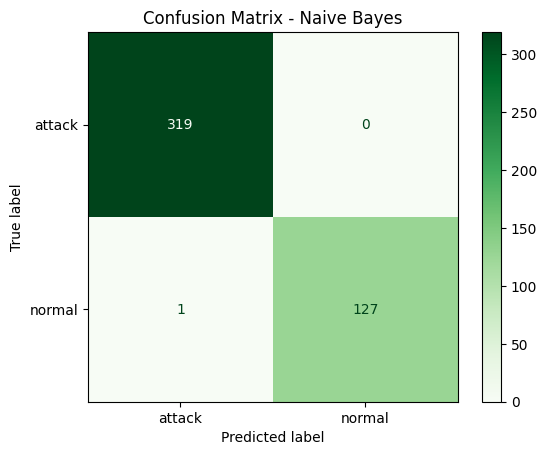

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm_nb = confusion_matrix(y_test, nb_predictions)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=nb_classifier.classes_)
disp_nb.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()
